In [11]:
import numpy as np
from qiskit.circuit.library import PauliFeatureMap
from sklearn.svm import SVC
import time
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load the Iris dataset
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target
df = pd.concat((df.iloc[:18,:], df.iloc[51:69,:]), ignore_index=True)
df = df.drop(columns=['petal width (cm)'])
y = df['target']
features = df.columns[:-1]
df_features = df[features]
scaler = StandardScaler()
x_data = scaler.fit_transform(df_features)
#24 train, 12 test. C(24,2)=276 circuits for train, 24*12=288 for test. Both < 300.
x_train, x_test, y_train, y_test = train_test_split(x_data, y, 
                                                    test_size=12, random_state=42)
feature_dim = 3

# Real device

In [4]:
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_ibm_runtime import Sampler, QiskitRuntimeService, Options
from qiskit_machine_learning.kernels import FidelityQuantumKernel

ImportError: cannot import name 'deprecate_func' from 'qiskit.utils.deprecation' (/home/mhassans/miniconda3/envs/myenv/lib/python3.10/site-packages/qiskit/utils/deprecation.py)

In [4]:
#from https://qiskit.org/providers/
# and https://qiskit.org/ecosystem/machine-learning/migration/01_migration_guide_0.5.html#New-quantum-kernel

In [5]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_manila")
options = Options(optimization_level=3, resilience_level=1)

In [6]:
sampler = Sampler(session=backend, options=options)

In [7]:
fidelity = ComputeUncompute(sampler=sampler)

In [8]:
paulis = [["X", "YZ"]]
reps = 2
entanglement = "linear"
feature_map = PauliFeatureMap(
               feature_dimension=feature_dim,
               alpha=0.5,
               reps=reps,
               paulis=paulis,
               entanglement=entanglement,
              )

In [9]:
kernelReal = FidelityQuantumKernel(feature_map=feature_map, fidelity=fidelity)

In [10]:
model = SVC(kernel = kernelReal.evaluate, C = 100, cache_size = 1000)

In [11]:
start_train = time.time()
model.fit(x_train, y_train)
end_train = time.time()

In [12]:
start_test = time.time()
dec_funcs = model.decision_function(x_test)
end_test = time.time()

In [13]:
dec_funcs

array([-0.83942999,  0.57015597,  0.73385591,  0.80960733,  0.35516125,
       -0.88424229, -0.24690282, -2.7310009 ,  0.96180315, -1.00248934,
       -1.9861457 , -0.82879835])

Text(0.5, 1.0, 'opt=3, res=1')

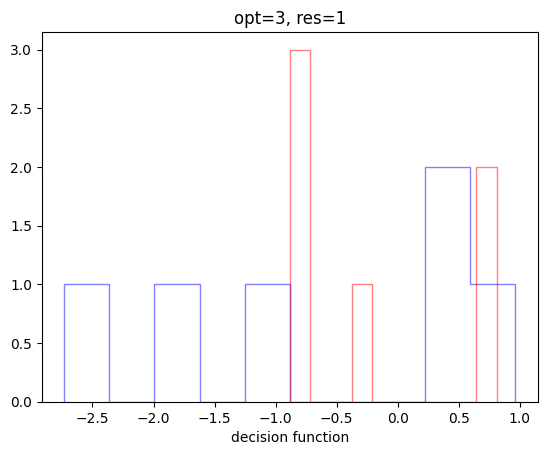

In [32]:
hist = plt.hist(dec_funcs[y_test==0], edgecolor='blue', alpha=0.5, histtype='step')
hist = plt.hist(dec_funcs[y_test==1], edgecolor='red', alpha=0.5, histtype='step')
plt.xlabel('decision function')
plt.title('opt=3, res=1')

# Simulation (updated libraries)

In [3]:
from qiskit_machine_learning.kernels import FidelityStatevectorKernel


In [24]:
class QKE_SVC():
    def __init__(self):
        paulis = [["X", "YZ"]]
        reps = 2
        entanglement = "linear"
        feature_map = PauliFeatureMap(
                       feature_dimension=feature_dim,
                       alpha=0.5,
                       reps=reps,
                       paulis=paulis,
                       entanglement=entanglement,
                      )
        self.kernel_func = FidelityStatevectorKernel(feature_map=feature_map, shots=1024, enforce_psd=False)        
        
    def kernel_from_subkernels(self, mtx1, mtx2=None):
        if mtx2 is None:
            mtx2 = mtx1
        dim1 = np.shape(mtx1)[0]
        dim2 = np.shape(mtx2)[0]
        kernel = np.zeros((dim1, dim2))
        subKernelDim = 10
        counter=0
        if (dim1/subKernelDim == dim1//subKernelDim) and (dim2/subKernelDim == dim2//subKernelDim):
            for i in range(dim1//subKernelDim):
                for j in range(dim2//subKernelDim):
                    kernel[i*subKernelDim:(i+1)*subKernelDim, j*subKernelDim:(j+1)*subKernelDim] = self.kernel_func.evaluate(mtx1[i*subKernelDim:(i+1)*subKernelDim], mtx2[j*subKernelDim:(j+1)*subKernelDim])
                    counter+=1
                    #print(counter)
        else:
            raise ValueError('subKernelDim is not a divisor of dimX or dimY. Modify the code to handle such cases.')
        return kernel
    
    def train_model(self, from_subkernels=False):
        if from_subkernels:
            model = SVC(kernel = self.kernel_from_subkernels, C = 100, cache_size = 1000)
        else:
            model = SVC(kernel = self.kernel_func.evaluate, C = 100, cache_size = 1000)
        return model
    

In [25]:
QKE_model = QKE_SVC()

In [26]:
modelSim = QKE_model.train_model(from_subkernels=False)

In [27]:
modelSim.fit(x_train, y_train)

SVC(C=100, cache_size=1000,
    kernel=<bound method FidelityStatevectorKernel.evaluate of <qiskit_machine_learning.kernels.fidelity_statevector_kernel.FidelityStatevectorKernel object at 0x7fd6e7526ec0>>)

In [28]:
dec_funcsSim = modelSim.decision_function(x_test)

In [29]:
dec_funcsSim

array([-2.63751402, -0.05247096, -0.528493  ,  4.85962683,  3.38895532,
       -6.45088451,  0.74798868, -8.85756704,  2.18614553, -4.5584239 ,
       -1.05772369, -4.5115584 ])

Text(0.5, 1.0, 'noiseless simulation; shots=inf')

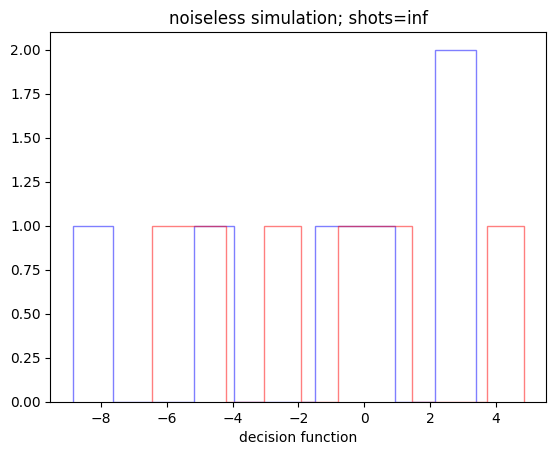

In [30]:
histSim = plt.hist(dec_funcsSim[y_test==0], edgecolor='blue', alpha=0.5, histtype='step')
histSim = plt.hist(dec_funcsSim[y_test==1], edgecolor='red', alpha=0.5, histtype='step')
plt.xlabel('decision function')
plt.title('noiseless simulation; shots=inf')

# A simple circuit 

In [ ]:
#from qiskit_ibm_provider import IBMProvider
#providerReal = IBMProvider()
#backendReal = providerReal.get_backend('ibmq_manila')